# **Analysis of Life Expectancy in the United Kingdom**

## **Introduction**

Life expectancy, a key indicator of a population's health(STIEFEL et al., 2010), refers to the average number of years a person can expect to live based on current mortality rates. Over time, life expectancy has been shaped by advancements in healthcare, nutrition, and living conditions(Spiers et al., 2021) with England having the highest life expectancy in the UK (Mckee et al., 2021). However, these improvements have not been uniform across populations. Factors such as socioeconomic status, geographic location, and access to healthcare can significantly influence life expectancy (Jackowska et al., 2024), with disparities becoming more pronounced in recent years.

In high-income countries, trends in life expectancy have been increasing, yet this improvement often masks the expansion of poor health, particularly as more individuals live with chronic diseases and disabilities (Spiers et al., 2021)​. Conversely, the impact of lifestyle factors, including diet, physical activity, and smoking, can be profound (Ghodeshwar et al., 2023), with studies showing that individuals in better socioeconomic conditions typically enjoy longer, healthier lives (Wang & Geng, 2019). Understanding the links between life expectancy and deprivation is crucial for addressing these inequities and formulating targeted public health policies. 

This research study aims to explore these relationships further, examining  can explain variations in life expectancy across different populations.

#### *Research Objectives*
This report aims to investigate the life expectancy of low income individuals and the effects of different factors such as deprivation, socioeconomic conditions, access to healthcare including other factors, by applying statistical and visual analytics. The study seeks to  evaluate its implications for public health policy.

#### *Key objectives:*
*1. To examine the correlation between life expectancy and indicators of low-income families.*

*2. To identify geographic disparities in life expectancy within the UK.*

*3. To assess how poverty-related factors such as unemployment influence life expectancy.*

*4. To propose targeted interventions to address disparities in health outcomes.*

## **Methodology**
#### *About the data:*

The study will be using 6 different datasets each of which correspond to a different aspect affecting life expectancy

*1. Income* 

*2. Index of multiple deprivation*

*3. Homelessness*

*4. Alcohol consumption*

*5. Unemployment*

*6. Life Expectancy*

The datasets have been sourced from Fingertips, the UK Office for National Statistics (ONS) and the National Health Service(NHS) websites. Care has been taken to ensure that the previous 10 years data is present in all datasets and they contain geographic identifiers such as Local Authority District codes and/or Area Names to allow accurate merging of data.

In [472]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tabulate import tabulate
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency, f_oneway
from sklearn.cluster import KMeans
import folium
from folium.plugins import DualMap

import warnings
warnings.filterwarnings('ignore')

## **Analysis**
#### **Exploratory analysis**

In [473]:
# Loading datasets
life_expectancy = pd.read_csv(r'data\Healthy life expectancy at birth.csv', encoding = "ISO-8859-1")
income = pd.read_csv(r'data\Net_Income Data.csv', encoding = "ISO-8859-1")
deprivation = pd.read_csv(r'data/Index of Multiple Deprivation.csv', encoding = "ISO-8859-1")
homeless = pd.read_csv(r'data\Homelessness.csv', encoding = "ISO-8859-1")
alcohol = pd.read_csv(r'data\Alochol_consumption.csv', encoding = "ISO-8859-1")
unemp = pd.read_csv(r'data\Unemployment.csv', encoding = "ISO-8859-1")
loc = pd.read_csv(r'C:\Users\gowda\Desktop\Gateshead_Council_HDRC\data\locations.csv')

In [474]:
# Cleaning life expectancy dataset
#Drop all columns except Area Code, Area Name, Area Type, Sex, Time period and Value / Remove null values from life expectancy for value column
life_expectancy = life_expectancy[[ 'Area Code', 'Area Name', 'Value']]
life_expectancy = life_expectancy[life_expectancy['Value'].notna()]

# Calculate the average life expectancy by area
average_life_expectancy = life_expectancy.groupby('Area Code')['Value'].mean().reset_index()
average_life_expectancy.rename(columns={'Value': 'Life Expectancy'}, inplace=True)
life_expectancy = life_expectancy.merge(average_life_expectancy, on='Area Code', how='left')
life_expectancy = life_expectancy.drop_duplicates(subset=['Area Code'])
life_expectancy.drop(columns={'Value'}, inplace=True)
life_expectancy.head()

,Area Code,Area Name,Life Expectancy
0,E92000001,England,55.729155
2,E06000001,Hartlepool,57.207700
3,E06000002,Middlesbrough,58.667891
4,E06000003,Redcar and Cleveland,59.684438
5,E06000004,Stockton-on-Tees,60.361191


In [475]:
# Cleaning income dataset #Drop all columns except Local authority code and Net annual income and rename columns
income = income[['Local authority code', 'Net annual income (£)']]
income.rename(columns={'Net annual income (£)': 'Net annual income'}, inplace=True)

# Ensure the Net annual income column is numeric (remove commas and convert to float)
income['Net annual income'] = income['Net annual income'].str.replace(',', '').astype(float)

# Group by Local authority code and calculate the mean of Net annual income
income = round(income.groupby('Local authority code')['Net annual income'].mean(),2).reset_index()
income.rename(columns={'Net annual income': 'Net Annual Income'}, inplace=True)
income.head()

,Local authority code,Net Annual Income
0,E06000001,27025.00
1,E06000002,27584.21
2,E06000003,28268.42
3,E06000004,30087.50
4,E06000005,29166.67


In [476]:
# Cleaning depravation dataset #Drop all columns except Area Code and Value
deprivation = deprivation[['Area Code', 'Value']]
deprivation.rename(columns={'Value': 'Deprivation'}, inplace=True)
deprivation.head()

,Area Code,Deprivation
0,E92000001,21.722087
1,E02000001,14.720484
2,E02000002,34.767560
3,E02000003,25.149726
4,E02000004,23.560044


In [477]:
# Cleaning homlessness dataset #Drop all columns except Area Code and Value and calculate the average Homelessness rate by area
homeless = homeless[['Area Code', 'Value']]

average_homeless = homeless.groupby('Area Code')['Value'].mean().reset_index()
average_homeless.rename(columns={'Value': 'Rate of Homelessness'}, inplace=True)
homeless = homeless.merge(average_homeless, on='Area Code', how='left')
homeless = homeless.drop_duplicates(subset=['Area Code'])
homeless.drop(columns={'Value'}, inplace=True)
homeless.head()

,Area Code,Rate of Homelessness
0,E92000001,1.773820
1,E06000001,0.309195
2,E06000002,0.653635
3,E06000003,0.218979
4,E06000004,0.440384


In [478]:
# Cleaning alcohol dataset #Drop all columns except Indicator name, Area Code and Value and calculate the average Homelessness rate by area
alcohol = alcohol[['Indicator Name', 'Area Code', 'Value']]
alcohol = alcohol.loc[(alcohol['Indicator Name'] == 'Alcohol-specific mortality') | 
                      (alcohol['Indicator Name'] == 'Alcohol-related mortality')] #Keep only values for alcohol mortalities
alcohol.drop(columns={'Indicator Name'}, inplace=True)

average_alcohol = alcohol.groupby('Area Code')['Value'].mean().reset_index()
average_alcohol.rename(columns={'Value': 'Deaths due to alcohol'}, inplace=True)
alcohol = alcohol.merge(average_alcohol, on='Area Code', how='left')
alcohol = alcohol.drop_duplicates(subset=['Area Code'])
alcohol.drop(columns={'Value'}, inplace=True)
alcohol.head()

,Area Code,Deaths due to alcohol
0,E92000001,27.500680
66,E06000001,39.737318
67,E06000002,39.019627
68,E06000003,32.348094
69,E06000004,33.742006


In [479]:
# Cleaning unemployment dataset #Drop all columns except Indicator name, Area Code and Value and calculate the average Homelessness rate by area
unemp = unemp[['Area Code', 'Value']]

average_unemp = unemp.groupby('Area Code')['Value'].mean().reset_index()
average_unemp.rename(columns={'Value': 'Unemployment rate'}, inplace=True)
unemp = unemp.merge(average_unemp, on='Area Code', how='left')
unemp = unemp.drop_duplicates(subset=['Area Code'])
unemp.drop(columns={'Value'}, inplace=True)
unemp.head()

,Area Code,Unemployment rate
0,E92000001,4.706747
1,A81001,9.701619
2,A81002,6.825429
3,A81003,18.678230
4,A81004,3.985297


In [480]:
# Merging datasets
data = life_expectancy.merge(income, left_on='Area Code', 
                             right_on='Local authority code', how='inner') #Merge life expectancy and net annual income datasets
data.drop(columns={'Local authority code'}, inplace=True)

data = data.merge(deprivation, left_on='Area Code', right_on='Area Code', how='inner') #Merging with deprivation dataset
data = data.merge(homeless, left_on='Area Code', right_on='Area Code', how='inner') #Merging with Homelessness dataset
data = data.merge(alcohol, left_on='Area Code', right_on='Area Code', how='inner') #Merging with alcohol dataset
data = data.merge(unemp, left_on='Area Code', right_on='Area Code', how='inner') #Merging with unemployment dataset
data = data.merge(loc, left_on='Area Name', right_on='Area Name', how='inner') #Merging with location dataset
data.head()

,Area Code,Area Name,Life Expectancy,Net Annual Income,Deprivation,Rate of Homelessness,Deaths due to alcohol,Unemployment rate,Latitude,Longitude
0,E06000001,Hartlepool,57.207700,27025.00,35.036693,0.309195,39.737318,7.471200,54.691745,-1.212926
1,E06000002,Middlesbrough,58.667891,27584.21,40.460346,0.653635,39.019627,8.766359,54.574227,-1.234956
2,E06000003,Redcar and Cleveland,59.684438,28268.42,29.791706,0.218979,32.348094,5.162157,54.539337,-1.031022
3,E06000004,Stockton-on-Tees,60.361191,30087.50,25.789576,0.440384,33.742006,4.707960,54.570455,-1.328982
4,E06000005,Darlington,62.029066,29166.67,25.657303,0.199020,33.591892,4.677431,54.523610,-1.559458


### **Statistical Analytics**

In [481]:
# Using Regression Analysis with all indicators as predictors to assess their combined effects
X = data[['Net Annual Income', 'Deprivation', 'Rate of Homelessness', 'Deaths due to alcohol', 'Unemployment rate']]
y = data['Life Expectancy'] 
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        Life Expectancy   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     141.6
Date:                Wed, 27 Nov 2024   Prob (F-statistic):           5.72e-47
Time:                        21:36:29   Log-Likelihood:                -189.13
No. Observations:                 119   AIC:                             390.3
Df Residuals:                     113   BIC:                             406.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    65.92

From the regression, we can see that the R-squared value of 0.862 suggests that approximately 86.2% of the variation in life expectancy is explained by the predictors included in the model, which is a strong fit. The p-values indicate that Net Annual Income, Deprivation, and Unemployment rate have statistically significant relationships with life expectancy, with very low p-values (below 0.05), suggesting that these factors have a meaningful impact. Specifically, a higher Net Annual Income is associated with increased life expectancy, while higher Deprivation and Unemployment rate are associated with lower life expectancy.

On the other hand, the Rate of Homelessness and Deaths due to alcohol are not statistically significant, as their p-values are above 0.05, meaning these variables do not have a significant impact on life expectancy in this model. 

The model also shows that there might be some multicollinearity, as indicated by the large condition number (5.22e+05), which suggests that the predictors may be highly correlated with each other, potentially affecting the stability of the coefficient estimates.

In [482]:
results = []
# 1. ANOVA for all relevant variables
variables = ['Life Expectancy', 'Rate of Homelessness', 'Unemployment rate', 'Deaths due to alcohol']
for var in variables:
    low_income_group = data[data['Net Annual Income'] < data['Net Annual Income'].quantile(0.33)][var]
    medium_income_group = data[(data['Net Annual Income'] >= data['Net Annual Income'].quantile(0.33)) & 
                               (data['Net Annual Income'] < data['Net Annual Income'].quantile(0.66))][var]
    high_income_group = data[data['Net Annual Income'] >= data['Net Annual Income'].quantile(0.66)][var]
    
    anova_result = f_oneway(low_income_group, medium_income_group, high_income_group)
    results.append({
        'Variable': var,
        'Analysis Type': 'ANOVA',
        'F-statistic': anova_result.statistic,
        'P-value': anova_result.pvalue
    })

# 2. Chi-Square Test for Categorical Variables
homelessness_high_low = pd.cut(data['Rate of Homelessness'], bins=[0, 3, 6], labels=['Low', 'High'])
income_groups = pd.cut(data['Net Annual Income'], bins=3, labels=['Low', 'Medium', 'High'])
contingency_table = pd.crosstab(income_groups, homelessness_high_low)

for var in variables:
    # Categorize the variable into low, medium, high groups
    if var == 'Rate of Homelessness':
        variable_group = pd.cut(data[var], bins=[0, 3, 6], labels=['Low', 'High'])
    else:
        # General method for continuous variables (Unemployment rate, Deaths due to alcohol)
        variable_group = pd.cut(data[var], bins=3, labels=['Low', 'Medium', 'High'])
    
    contingency_table = pd.crosstab(income_groups, variable_group)
    chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
    results.append({
        'Variable': var,
        'Analysis Type': 'Chi-Square',
        'Chi2-statistic': chi2_stat,
        'P-value': p_val
    })

chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
results.append({
    'Variable': 'Rate of Homelessness',
    'Analysis Type': 'Chi-Square',
    'Chi2-statistic': chi2_stat,
    'P-value': p_val
})

# 3. Gini Index for each relevant variable (using Lorenz curve method)
variables_to_analyze = ['Net Annual Income', 'Life Expectancy', 'Rate of Homelessness', 'Unemployment rate', 'Deaths due to alcohol']
for var in variables_to_analyze:
    variable = data[var].dropna()
    sorted_variable = np.sort(variable)
    n = len(sorted_variable)
    cumulative_variable = np.cumsum(sorted_variable)
    lorenz_curve = cumulative_variable / cumulative_variable[-1]
    gini_value = 1 - 2 * np.trapz(lorenz_curve, dx=1/n)
    results.append({
        'Variable': var,
        'Analysis Type': 'Gini Index',
        'Gini Index': gini_value
    })

df_results = pd.DataFrame(results)
df_results.insert(0, 'Analysis', df_results.pop('Analysis Type'))
print(tabulate(df_results, headers='keys', tablefmt='pretty', showindex=False))

+------------+-----------------------+-------------------+------------------------+--------------------+----------------------+
|  Analysis  |       Variable        |    F-statistic    |        P-value         |   Chi2-statistic   |      Gini Index      |
+------------+-----------------------+-------------------+------------------------+--------------------+----------------------+
|   ANOVA    |    Life Expectancy    | 47.98821583875409 | 6.514542182574653e-16  |        nan         |         nan          |
|   ANOVA    | Rate of Homelessness  | 16.90744158952126 | 3.6006067969660253e-07 |        nan         |         nan          |
|   ANOVA    |   Unemployment rate   | 9.132802696887627 | 0.00020730341692791278 |        nan         |         nan          |
|   ANOVA    | Deaths due to alcohol | 62.63313523130823 | 3.578985552333001e-19  |        nan         |         nan          |
| Chi-Square |    Life Expectancy    |        nan        | 6.166549959416935e-10  | 48.88631657914478  |

**ANOVA Results**: 

- The F-statistics and p-values from the ANOVA tests for Life Expectancy, Rate of Homelessness, Unemployment rate, and Deaths due to alcohol all show significant differences between income groups (p-values are close to 0). This means that income has a notable effect on each of these variables, with substantial variation across low, medium, and high-income areas.

**Chi-Square Test Results**:

- For the Life Expectancy, Rate of Homelessness, Unemployment rate, and Deaths due to alcohol, all chi-square tests show highly significant p-values (below 0.01), meaning there is a strong association between income groups and these socio-economic variables. 

- Specifically, Life Expectancy has a p-value of 6.17e-10, indicating a very strong relationship with income levels.

- The Rate of Homelessness also shows a significant chi-square statistic (48.89) with a p-value of 0.0022, pointing to a significant dependency on income. 

- The Unemployment rate and Deaths due to alcohol similarly show strong chi-square statistics (17.16 and 50.24, respectively), both with p-values indicating a clear connection between these variables and income groups.

**Gini Index**: 
- The Gini Index values for Net Annual Income (0.098), Life Expectancy (0.029), Rate of Homelessness (0.424), Unemployment rate (0.214), and Deaths due to alcohol (0.113) indicate the level of inequality within each variable.

- Net Annual Income shows the lowest inequality (0.098), suggesting that income is more evenly distributed in the population.

- Life Expectancy shows an even lower inequality (0.029), indicating that life expectancy is almost uniform across income groups.

- Rate of Homelessness (0.424) and Unemployment rate (0.214) exhibit more inequality, with homelessness showing the highest inequality among the variables. 

- Deaths due to alcohol have a moderate level of inequality (0.113), reflecting some disparity, but not as pronounced as homelessness.

**Summary**: The analysis confirms that income strongly influences life expectancy, homelessness, unemployment, and deaths due to alcohol, with each variable showing significant differences across income groups. The chi-square test results emphasize that these variables are closely tied to income. Inequality is most prominent in homelessness and unemployment, while income and life expectancy show lower levels of inequality. 

These findings suggest that lower-income areas experience worse socio-economic outcomes, especially in terms of homelessness and unemployment, and highlight the deep disparities in the data.

### **Visual Analytics**

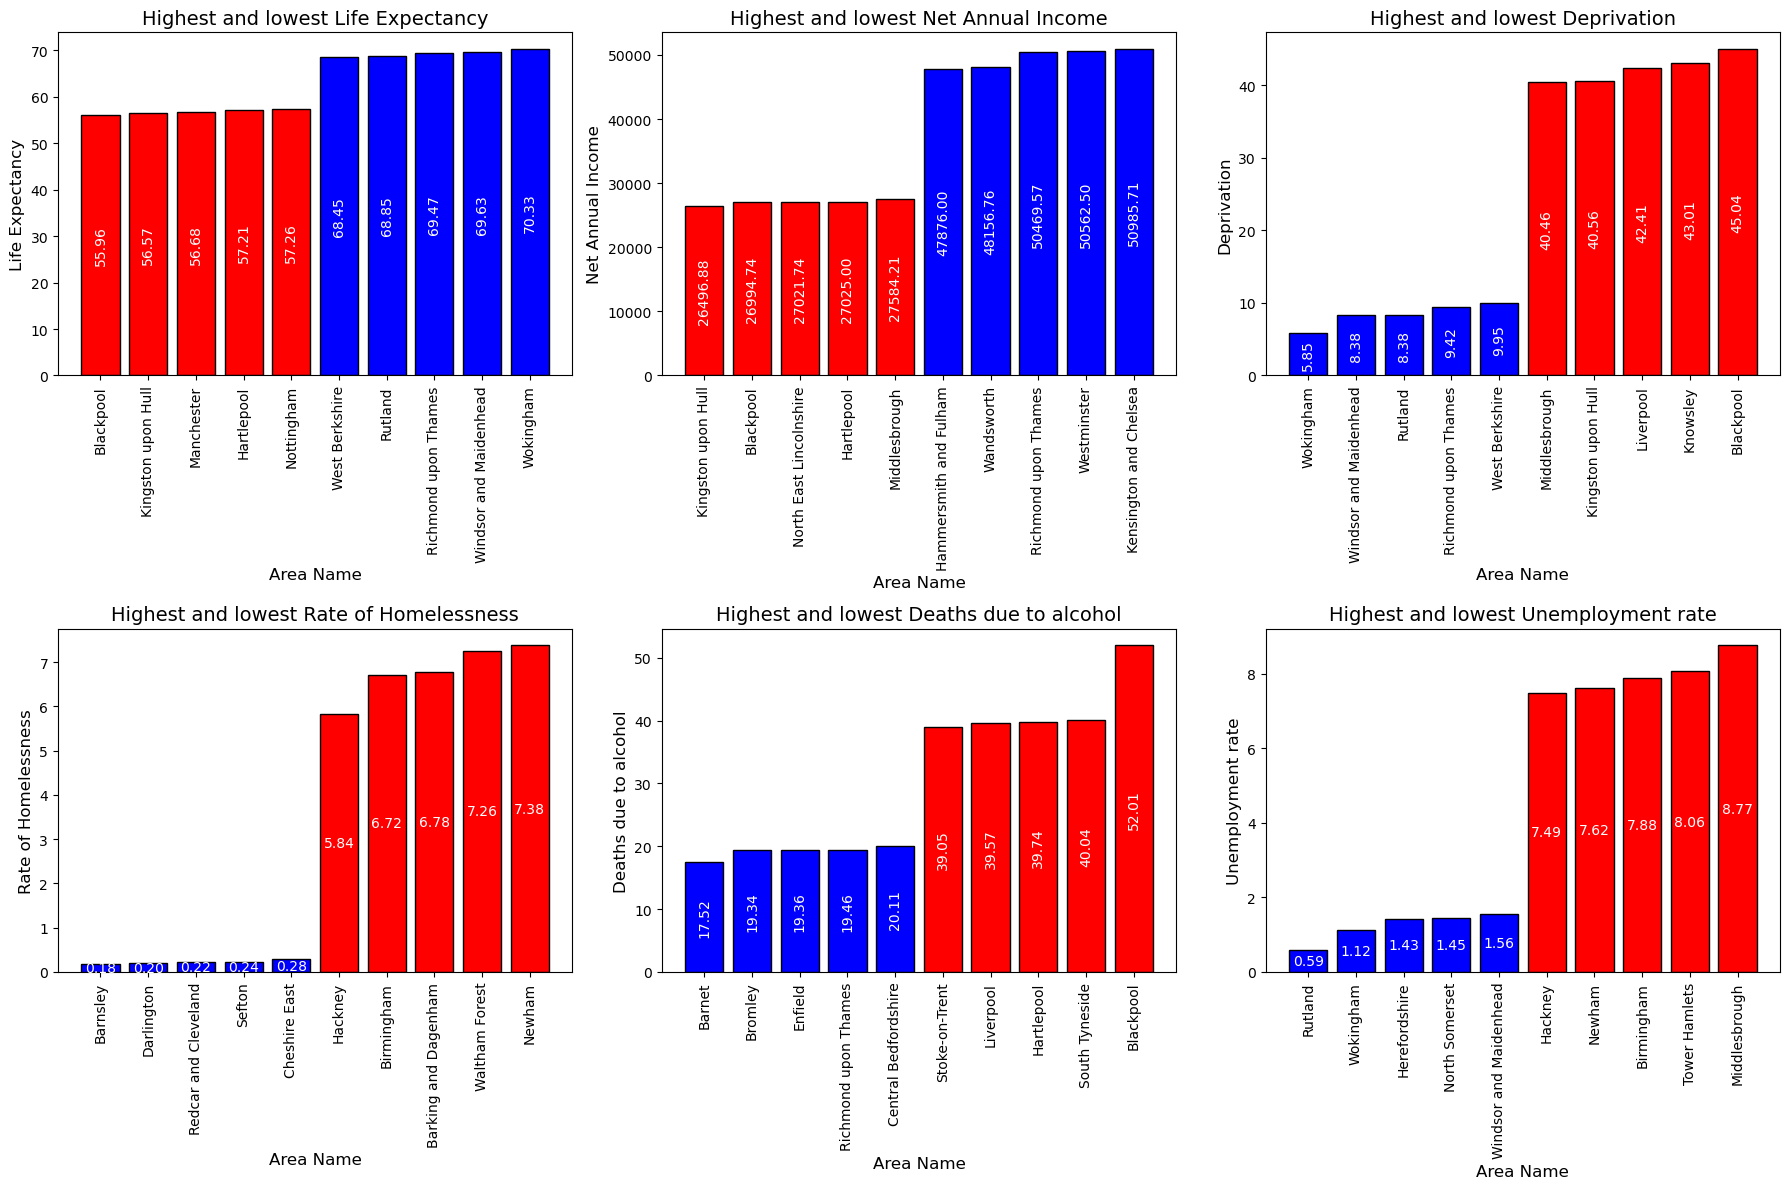

In [483]:
columns_to_plot = data.loc[:, ~data.columns.isin(['Area Code', 'Area Name', 'Latitude', 'Longitude'])]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))  # 2 rows, 3 columns
axes = axes.flatten()  # Flatten the 2D array of axes to make it easier to index

for i, column in enumerate(columns_to_plot):
    sorted_df = data.sort_values(by=column, ascending=True)
    top_bottom_df = pd.concat([sorted_df.head(5), sorted_df.tail(5)])
    if column in ['Life Expectancy', 'Net Annual Income']:
        colors = ['red'] * 5 + ['blue'] * 5
    else:
        colors = ['blue'] * 5 + ['red'] * 5
    
    bars = axes[i].bar(top_bottom_df["Area Name"], top_bottom_df[column], color=colors, edgecolor='black')
    for bar, value in zip(bars, top_bottom_df[column]):
        if (column in ['Unemployment rate', 'Rate of Homelessness']):
            axes[i].text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() / 2,
                f"{value:.2f}",
                ha='center', va='center', fontsize=10, color='white', rotation = 0
            )
        else:
            axes[i].text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() / 2,
                f"{value:.2f}",
                ha='center', va='center', fontsize=10, color='white', rotation = 90
            )

    axes[i].set_title(f"Highest and lowest {column}", fontsize=14)
    axes[i].set_xlabel("Area Name", fontsize=12)
    axes[i].set_ylabel(column, fontsize=12)
    axes[i].tick_params(axis='x', rotation=90)
plt.tight_layout()  # Adjust subplots to fit into the figure area
plt.show()

The set of bar graphs presents a comparison of various socio-economic and health indicators across different areas. 

- The first plot shows Life Expectancy, highlighting the lowest values in areas like Blackpool and Kingston upon Hull, and the highest in regions like Wokingham and Richmond upon Thames. 

- The second graph contrasts Net Annual Income, with areas like Kingston upon Hull and Blackpool showing the lowest incomes, while Westminster and Wokingham report the highest. 

- The third plot focuses on Deprivation, where Blackpool and Kingston upon Hull are among the highest, with Wokingham and Windsor and Maidenhead having the lowest deprivation levels.

- In the fourth graph, Rate of Homelessness is depicted, with areas such as Barnsley and Barking and Dagenham showing the highest rates of homelessness, while areas like Newham and Cheshire East have the lowest. 

- The fifth plot compares Deaths Due to Alcohol, where the highest mortality rates are found in Blackpool and South Tyneside, and the lowest in areas like Barnet and Enfield. 

- Lastly, the sixth graph shows the Unemployment Rate, with Blackpool and Middlesbrough experiencing the highest unemployment rates, and regions like Rutland and Wokingham exhibiting the lowest rates.

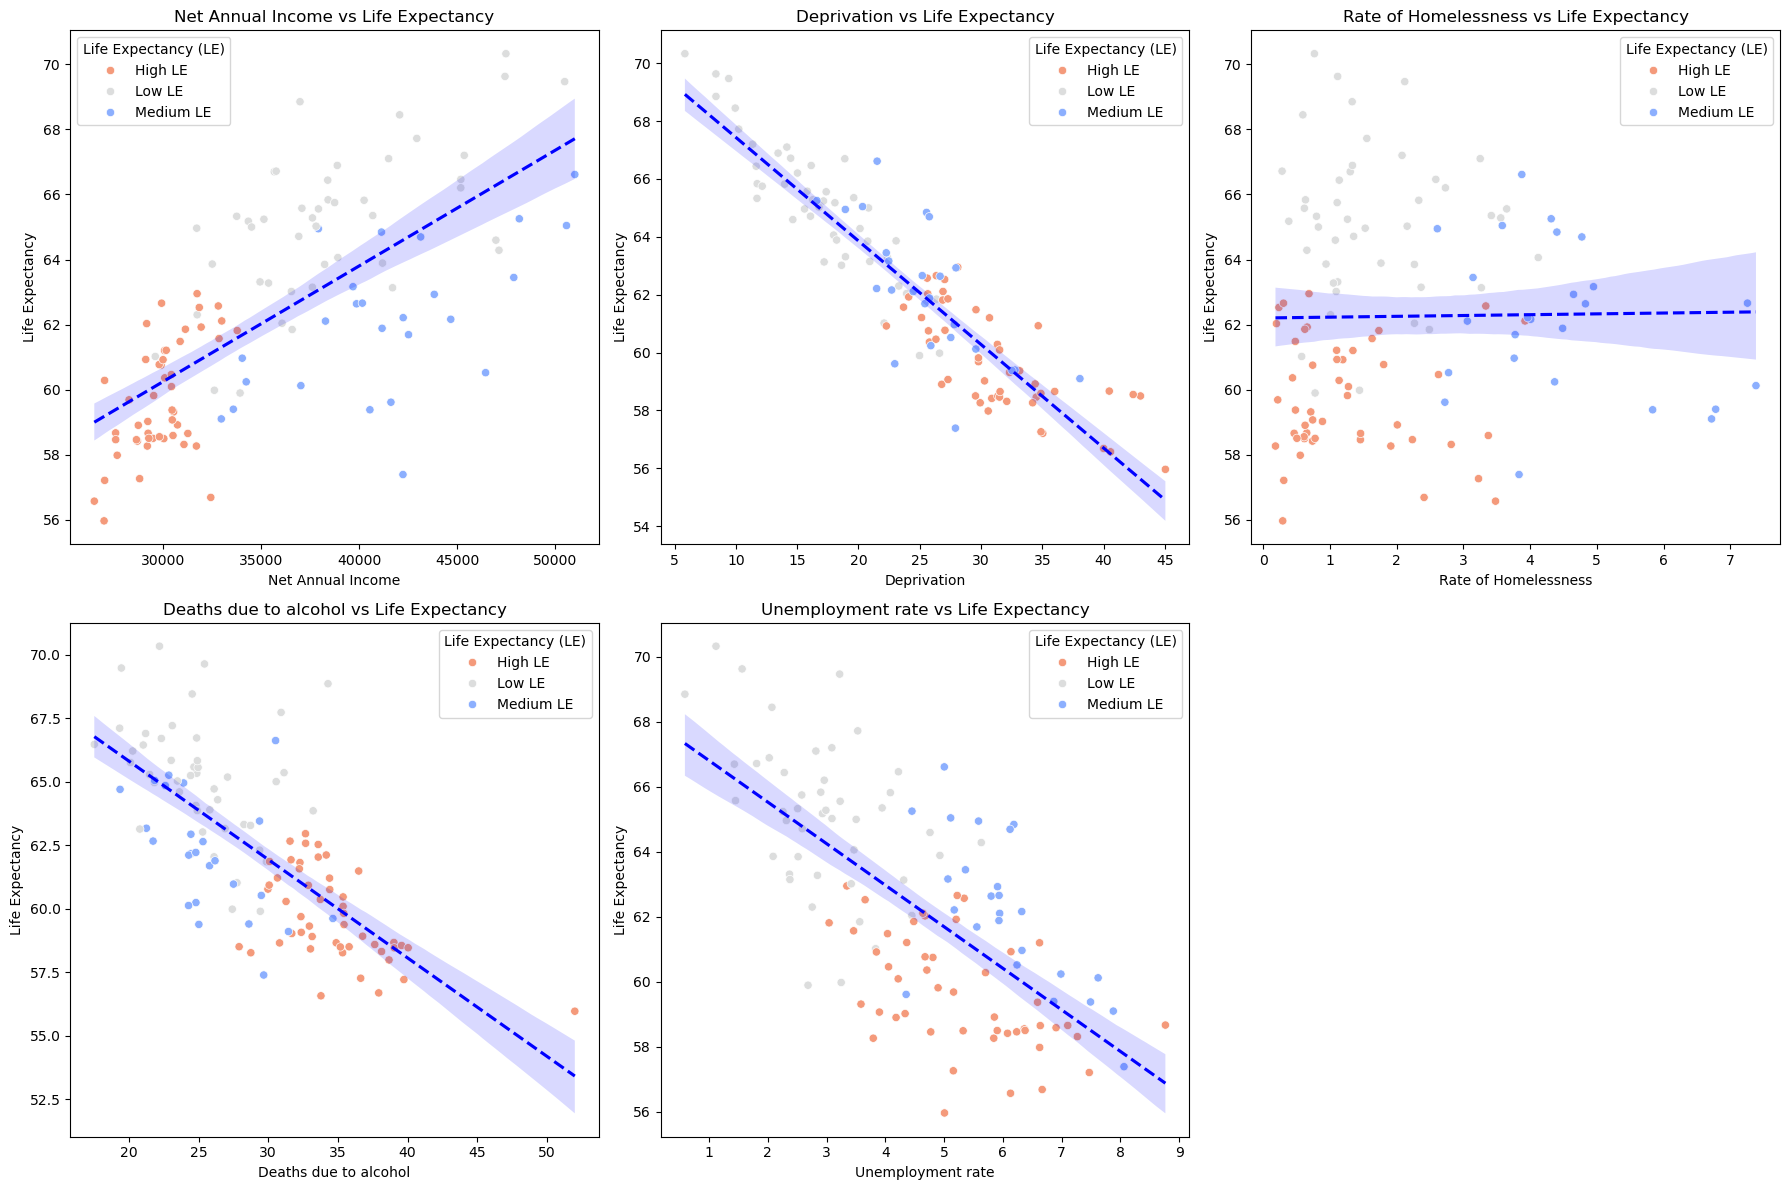

In [484]:
#Cluster analsis
scatter_pairs = [
    ('Net Annual Income', 'Life Expectancy'),
    ('Deprivation', 'Life Expectancy'),
    ('Rate of Homelessness', 'Life Expectancy'),
    ('Deaths due to alcohol', 'Life Expectancy'),
    ('Unemployment rate', 'Life Expectancy')
]

features_for_clustering = ['Net Annual Income', 'Deprivation', 'Rate of Homelessness', 
                         'Deaths due to alcohol', 'Unemployment rate']

#Standardizing the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[features_for_clustering])

X = data_scaled
kmeans = KMeans(n_clusters=3, random_state=42)
data['Cluster'] = kmeans.fit_predict(X)
cluster_names = {0: 'Low LE', 1: 'Medium LE', 2: 'High LE'}
data['Cluster Name'] = data['Cluster'].map(cluster_names)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (x_feature, y_feature) in enumerate(scatter_pairs):
    sns.scatterplot(data=data, x=x_feature, y=y_feature, hue='Cluster Name', palette='coolwarm_r', ax=axes[i])
    sns.regplot(data=data, x=x_feature, y=y_feature, scatter=False, ax=axes[i], color='blue', line_kws={'linestyle': '--'})
    axes[i].set_title(f'{x_feature} vs {y_feature}')
    axes[i].set_xlabel(x_feature)
    axes[i].set_ylabel(y_feature)
    axes[i].legend(title='Life Expectancy (LE)', loc='best')

for j in range(len(scatter_pairs), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
data = data.drop(columns={'Cluster', 'Cluster Name'})
plt.show()

These cluster analysis reveals strong relationships between various socioeconomic factors and life expectancy. There's a clear positive correlation between net annual income and life expectancy, with higher incomes associated with longer lives. 

Conversely, there are strong negative correlations with deprivation, deaths due to alcohol, and unemployment rate - as these factors increase, life expectancy decreases significantly. Interestingly, the rate of homelessness shows a relatively flat relationship with life expectancy, suggesting a weaker direct impact compared to other factors.

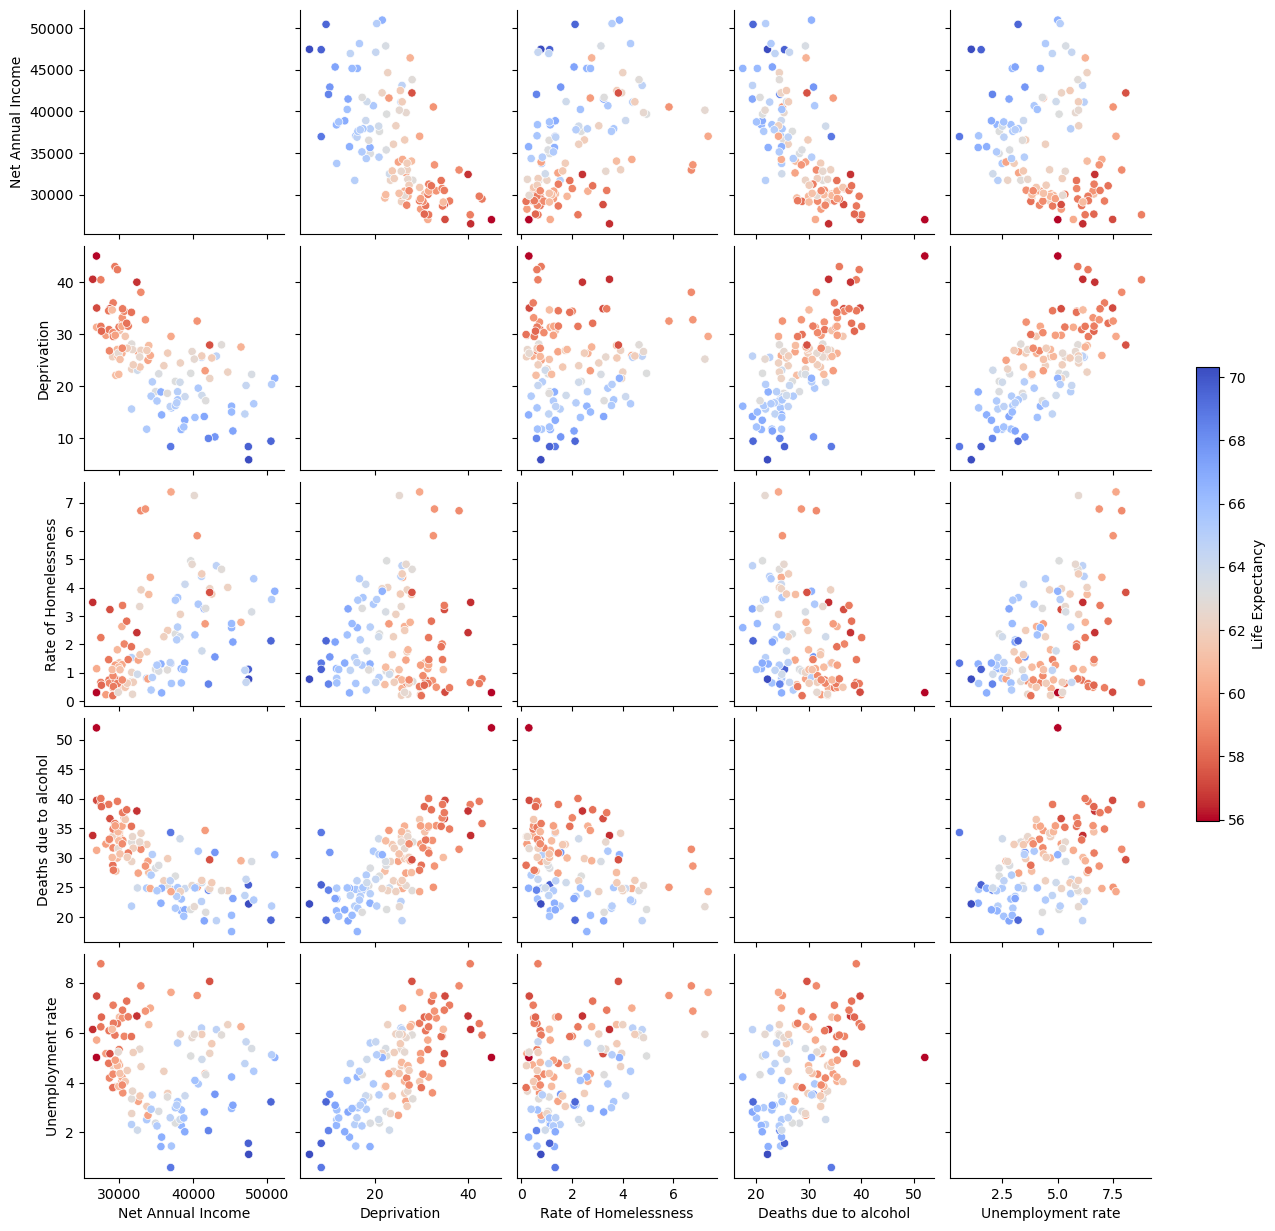

In [485]:
plot = sns.pairplot(
    data.loc[:, ~data.columns.isin(['Latitude', 'Longitude'])],
    kind='scatter', diag_kind='kde', palette='coolwarm_r',
    hue='Life Expectancy', height=2.5,)

plot._legend.remove()
norm = plt.Normalize(vmin=data['Life Expectancy'].min(), vmax=data['Life Expectancy'].max())
plt.cm.ScalarMappable(cmap='coolwarm_r', norm=norm).set_array([])

plot.figure.colorbar(plt.cm.ScalarMappable(cmap='coolwarm_r', norm=norm), 
                     ax=plot.axes, orientation='vertical', fraction=0.02, pad=0.04, label='Life Expectancy')
plt.show()

This pairplot provides a comprehensive view of how all variables interact with each other, not just with life expectancy. It reveals some interesting secondary relationships: areas with higher deprivation tend to have higher unemployment rates and more alcohol-related deaths, while areas with higher net annual income generally show lower rates of deprivation. 

The color coding (blue to red) helps visualize how life expectancy varies across these different dimensions, with darker blue points  associated with better life expectancy.

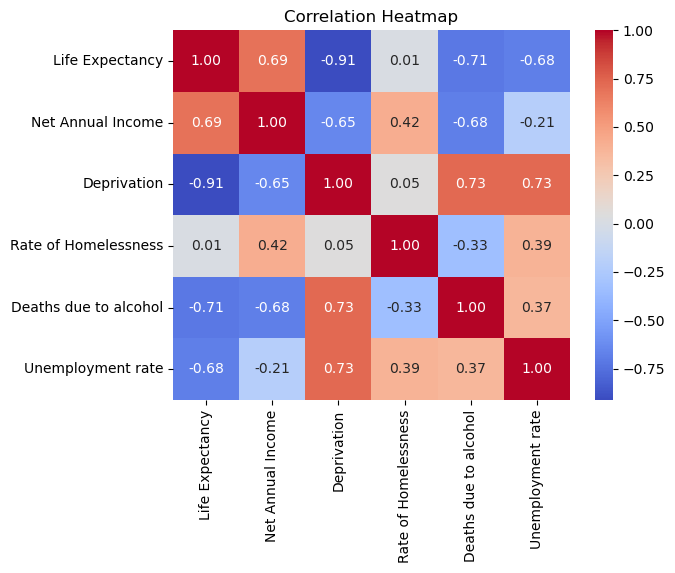

In [486]:
# Compute correlation matrix
corr_matrix = data.loc[:, ~data.columns.isin(['Area Code', 'Area Name', 'Latitude', 'Longitude'])].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

This visualization quantifies the strength and direction of relationships between all variables. The most striking correlation is the strong negative relationship between deprivation and life expectancy (-0.91), suggesting that deprivation is possibly the strongest predictor of reduced life expectancy. Net annual income shows a moderate positive correlation (0.69) with life expectancy, while deaths due to alcohol (-0.71) and unemployment rate (-0.68) show strong negative correlations. Notably, the rate of homelessness has an almost zero correlation (0.01) with life expectancy, confirming the flat relationship observed in the trend graphs.

### **Geographic Analysis**

In [487]:
map_center = [data['Latitude'].mean(), data['Longitude'].mean()]
dual_map = DualMap(location=map_center, zoom_start=10, control_scale=True)
def get_color(value, type):
    thresholds = {
        'deprivation': [(40, "maroon"), (30, "red"), (20, "orange"), (0, "green")],
        'life_expectancy': [(65, "green"), (60, "orange"), (58, "red"), (55, "brown")],
        'income': [(45000, "green"), (40000, "orange"), (35000, "red"), (30000, "brown"),(25000, "black")],
        'homelessness': [(6, "maroon"), (4, "red"), (2, "orange"), (0, "green")],
        'alcohol_deaths': [(40, "maroon"), (30, "red"), (20, "orange"), (0, "green")],
        'unemployment_rate': [(8, "maroon"), (6, "red"), (4, "orange"), (2, "green")]
    }

    if type in thresholds:
        for threshold, color in thresholds[type]:
            if value > threshold:  
                return color
    return "green"  # Default color if no threshold is matched

layers = {
    "Life Expectancy": "Life Expectancy",
    "Net Annual Income": "Net Annual Income",
    "Deprivation": "Deprivation",
    "Rate of Homelessness": "Rate of Homelessness",
    "Deaths due to alcohol": "Deaths due to alcohol",
    "Unemployment": "Unemployment rate"
}

type_mapping = {
    "Life Expectancy": "life_expectancy",
    "Net Annual Income": "income",
    "Deprivation": "deprivation",
    "Rate of Homelessness": "homelessness",
    "Deaths due to alcohol": "alcohol_deaths",
    "Unemployment": "unemployment_rate"
}

layers_group_m1 = {}
layers_group_m2 = {}

for layer_name, column_name in layers.items():
    layer_m1 = folium.FeatureGroup(name=layer_name)
    layer_m2 = folium.FeatureGroup(name=layer_name)

    for _, row in data.iterrows():
        value = row[column_name]
        type_key = type_mapping[layer_name]
        color = get_color(value, type_key)

        folium.CircleMarker(
            location=(row['Latitude'], row['Longitude']),
            radius=7,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7,
            tooltip=f"{row['Area Name']}: {value}"
        ).add_to(layer_m1)

        folium.CircleMarker(
            location=(row['Latitude'], row['Longitude']),
            radius=7,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7,
            tooltip=f"{row['Area Name']}: {value}"
        ).add_to(layer_m2)

    layer_m1.add_to(dual_map.m1)
    layer_m2.add_to(dual_map.m2)
    layers_group_m1[layer_name] = layer_m1
    layers_group_m2[layer_name] = layer_m2

folium.LayerControl(collapsed=False).add_to(dual_map.m1)
folium.LayerControl(collapsed=False).add_to(dual_map.m2)
dual_map

In [ ]:
# Normalize the columns to ensure equal contribution to the composite score
for col in ['Life Expectancy', 'Net Annual Income', 'Deprivation', 'Rate of Homelessness', 'Deaths due to alcohol', 'Unemployment rate']:
    data[f'Normalized {col}'] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())

# Weights for each metric
weights = {
    'Life Expectancy': 0.35,
    'Net Annual Income': 0.20,
    'Deprivation': 0.15,
    'Rate of Homelessness': 0.05,
    'Deaths due to alcohol': 0.05,
    'Unemployment rate': 0.20
}

# Calculate the composite score
data['Composite Score'] = (
    weights['Life Expectancy'] * data['Normalized Life Expectancy'] +
    weights['Net Annual Income'] * data['Normalized Net Annual Income'] -
    weights['Deprivation'] * data['Normalized Deprivation'] -
    weights['Rate of Homelessness'] * data['Normalized Rate of Homelessness'] -
    weights['Deaths due to alcohol'] * data['Normalized Deaths due to alcohol'] -
    weights['Unemployment rate'] * data['Normalized Unemployment rate']
)

# Rank and sort locations based on composite score
data['Rank'] = data['Composite Score'].rank(ascending=False)
data = data.sort_values(by='Rank')

# Display the top and bottom 5 ranked locations
data.insert(0, 'Rank', data.pop('Rank'))
data.insert(3, 'Comp_score', data.pop('Composite Score'))
print(tabulate(pd.concat([data.loc[:, ~data.columns.isin(['Area Code', 'Latitude', 'Longitude'])].iloc[:, :8].head(5),
                            data.loc[:, ~data.columns.isin(['Area Code', 'Latitude', 'Longitude'])].iloc[:, :8].tail(5)]), headers='keys', tablefmt='fancy_grid', showindex=False))


╒════════╤════════════════════════╤══════════════╤═══════════════════╤═════════════════════╤═══════════════╤════════════════════════╤═════════════════════════╕
│   Rank │ Area Name              │   Comp_score │   Life Expectancy │   Net Annual Income │   Deprivation │   Rate of Homelessness │   Deaths due to alcohol │
╞════════╪════════════════════════╪══════════════╪═══════════════════╪═════════════════════╪═══════════════╪════════════════════════╪═════════════════════════╡
│      1 │ Wokingham              │     0.497549 │           70.3297 │             47475   │       5.84599 │               0.768066 │                 22.1961 │
├────────┼────────────────────────┼──────────────┼───────────────────┼─────────────────────┼───────────────┼────────────────────────┼─────────────────────────┤
│      2 │ Windsor and Maidenhead │     0.452483 │           69.6308 │             47427.8 │       8.37549 │               1.11667  │                 25.425  │
├────────┼────────────────────────┼─────

The top-performing areas reveal a striking pattern of prosperity: Wokingham leads with the highest life expectancy (70.3 years) and one of the highest net annual incomes (£47,475). These top 5 areas consistently show high life expectancy (68-70 years), high income (£37,000-£50,000), and low deprivation scores (5-10). They also tend to have relatively moderate rates of homelessness and lower deaths due to alcohol, suggesting better overall social conditions.

In stark contrast, the bottom 5 areas, including Manchester, Hartlepool, Middlesbrough, Kingston upon Hull, and Blackpool, paint a concerning picture of inequality. Life expectancy drops dramatically to around 55-58 years (nearly 15 years less than top areas), while incomes are significantly lower (£26,000-£32,000). These areas also face much higher deprivation scores (35-45) and generally higher rates of alcohol-related deaths, with Blackpool showing the highest at 52 deaths per 100,000 population.

The disparities between the best and worst-performing areas highlight a significant north-south divide in England, with the top areas predominantly located in the affluent south (Wokingham, Windsor and Maidenhead, Richmond upon Thames) and the bottom areas mainly in the north (Manchester, Hartlepool, Middlesbrough). This suggests deep-rooted regional inequalities in health, wealth, and social conditions that significantly impact life outcomes.

## **Discussion**
*Causes of low life expectancy in high deprivation areas*

- **Historical Industrial Decline**:
The northern regions, particularly areas like Middlesbrough, Hull, and Hartlepool, suffered significantly from the decline of traditional industries (steel, shipping, mining) during the 1980s. According to studies, these areas never fully recovered from this deindustrialization, leading to persistent unemployment and lower economic opportunities (Centre for Cities, 2022; Price et al., 2024).

- **Investment Disparities**:
The report titled "Make No Little Plans" (The UK2070 Reports, 2020) shows that London and the South East receive significantly more public investment per capita in infrastructure and transport. The report shows that London receives £1,500 more per person in transport spending than the North. 

- **Education and Skills Gap**:
A report by (Social Mobility Commission, 2021) highlights that areas like Wokingham  and Richmond upon Thames benefit from proximity to high-skilled job markets and better educational opportunities (Mowl, 2024; EMPLOYMENT and SKILLS STRATEGY, 2022). The northern areas often face what's called a "brain drain" where talented young people move south for better opportunities (Swinney & Williams, 2016), further depleting local human capital.

- **Health Infrastructure**:
One study reports that areas with higher deprivation scores typically have fewer GPs per capita and more stretched health services (RCGP, 2024). Blackpool, with its high deprivation score, faces significant challenges in healthcare access and higher rates of preventable health conditions (Blackpool Public Health Annual Report, 2024).

- **Housing Market Dynamics**:
Areas like Windsor and Maidenhead benefit from their proximity to London's economic hub, driving up property values and attracting higher-income residents (Housing Outlook • Resolution Foundation, 2023). In contrast, areas like Kingston upon Hull face challenges with lower property values, which affect local authority income and available resources for public services(Council, 2024).

- **Policy Centralization**:
The UK has one of the most centralized governments in the developed world, with limited regional autonomy (Agbonlahor, 2015). This centralization has historically favored London and the South East in decision-making and resource allocation, contributing to regional inequalities (Westwood & Kenny, 2024).

From these sources, it's clear that the current disparities are the result of a complex interplay of historical, economic, and policy factors that have created and reinforced regional inequalities over several decades.

***Solutions and Recommendations***

Based on the data analysis and broader research, several evidence-based solutions emerge to address the stark life expectancy gap between high and low-income areas. Primary interventions should focus on targeted healthcare investment in deprived areas like Blackpool and Kingston upon Hull, where life expectancy is around 56 years compared to 70 years in more affluent areas. This could include establishing more local health centers, implementing mobile health units, and increasing the number of healthcare professionals in these regions. Economic development initiatives are equally crucial - the data shows a strong correlation (0.69) between annual income and life expectancy, suggesting that programs focused on job creation, skills training, and small business support could have significant health impacts. 

Community-level interventions should address the contributing factors revealed in the analysis, particularly the strong correlation between deprivation and reduced life expectancy (-0.91). This could include improving access to healthy food through food cooperative programs, creating more green spaces and recreational facilities, and establishing community health education programs. The data also shows a significant correlation (-0.71) between alcohol-related deaths and reduced life expectancy, indicating the need for enhanced addiction support services and preventive education in vulnerable communities. 

These interventions should be implemented as part of a coordinated strategy, with regular monitoring and evaluation to ensure their effectiveness in reducing health inequalities.

## **Future work**

- **Temporal Analysis**: Track changes in life expectancy and income inequality over 10-20 years to identify long-term trends and policy impacts.

- **Granular Geographic Analysis**: Break down data by neighborhood level rather than just area level to identify micro-patterns and local factors

- **Demographic Segmentation**: Analyze how age, gender, and ethnic backgrounds intersect with income and life expectancy

- **Healthcare Access Mapping**: Overlay data with distance to medical facilities, GP ratios, and emergency response times


  ***Advanced Statistical Methods***
- **Machine Learning Models**: Develop predictive models to forecast life expectancy based on socioeconomic indicators

- **Time Series Analysis**: Study seasonal and cyclical patterns in health outcomes and their relationship to economic cycles

- **Multivariate Regression**: 

    Include additional variables such as:
  - Education levels and school quality metrics
  - Environmental factors (air quality, green space access)
  - Food security and nutrition indicators
  - Local healthcare spending and resource allocation

- **Policy Impact Assessment**
  - **Natural Experiments**: Study the impact of local policy changes on life expectancy
  - **Cost-Benefit Analysis**: Calculate the economic returns of various intervention strategies
  - **International Comparisons**: Benchmark against similar regions in other countries
  - **Policy Simulation**: Model the potential impact of proposed interventions before implementation

- **Data Enhancement**
  - **Qualitative Research**: Incorporate community surveys and interviews
  - **Health Behavior Data**: Include lifestyle factors, diet, and exercise patterns
  - **Social Mobility Metrics**: Track intergenerational changes in health outcomes
  - **Economic Opportunity Data**: Map job availability and career progression paths

## **Conclusion**

The data presented here paints a vivid picture of how historical, economic, educational, health, housing, and political factors have combined to create and reinforce regional inequalities in England. The disparities in life expectancy, income, and health outcomes are not random but the result of systemic issues that have shaped the development of different regions. While some areas enjoy prosperity and access to resources, others continue to struggle with deep-rooted challenges that limit their residents' life chances. 

To address these inequalities, targeted interventions are needed, including investment in healthcare, education, infrastructure, and housing, alongside efforts to decentralize power and decision-making to ensure that all regions have the resources they need to thrive. Only through such comprehensive, long-term strategies can the growing divide between north and south be bridged.

## **References**

Agbonlahor, W. (2015). UK “almost most centralised developed country”, says Treasury chief - Global Government Forum. Globalgovernmentforum.com. https://www.globalgovernmentforum.com/uk-most-centralised-developed-country-says-treasury-chief/

Blackpool Public Health Annual Report. (2024). https://www.blackpooljsna.org.uk/Documents/Public-Health-Annual-Reports/Public-Health-Annual-Report-2024-Final.pdf

‌Cities Outlook 2022 - Centre for Cities. (2023, December 14). Centre for Cities. https://www.centreforcities.org/publication/cities-outlook-2022/

‌Council, H. C. (2024). Home – Hull. Hull. https://www.hull.gov.uk/

EMPLOYMENT AND SKILLS STRATEGY. (2022). https://www.richmond.gov.uk/media/20106/richmond_employment_and_skills_strategy.pdf

Ghodeshwar, G. K., Dube, A., & Khobragade, D. (2023). Impact of Lifestyle Modifications on Cardiovascular Health: A Narrative Review. Cureus. https://doi.org/10.7759/cureus.42616

‌Jackowska, B., Piotr Wiśniewski, Tomasz Noiński, & Piotr Bandosz. (2024). Effects of lifestyle-related risk factors on life expectancy: A comprehensive model for use in early prevention of premature mortality from noncommunicable diseases. PLoS ONE, 19(3), e0298696–e0298696. https://doi.org/10.1371/journal.pone.0298696

‌Mckee, M., Dunnell, K., Anderson, M., Brayne, C., Charlesworth, A., Johnston-Webber, C., Knapp, M., Mcguire, A., Newton, J., Taylor, D., & Watt, R. (2021). Health Policy The changing health needs of the UK population. https://pmc.ncbi.nlm.nih.gov/articles/PMC9751760/pdf/main.pdf

Mowl, O. E. (2024, August 17). Reading named best towns for job opportunities. Reading Chronicle. https://www.readingchronicle.co.uk/news/24524661.reading-named-best-towns-job-opportunities/

‌Price, T., McGowan, V., Shelina Vishram, Wildman, J., & Bambra, C. (2024). “They’re not mentally ill, their lives are just shit”: Stakeholders’ understanding of deaths of despair in a deindustrialised community in North East England. Health & Place, 90, 103346–103346. https://doi.org/10.1016/j.healthplace.2024.103346

RCGP. (2024, October 3). GPs in deprived areas responsible for almost 2,500 patients per head. Rcgp.org.uk; RCGP. https://www.rcgp.org.uk/News/research-statement-conference-2024

‌Spiers, G. F., Tafadzwa Patience Kunonga, Beyer, F., Craig, D., Hanratty, B., & Jagger, C. (2021). Trends in health expectancies: a systematic review of international evidence. BMJ Open, 11(5), e045567–e045567. https://doi.org/10.1136/bmjopen-2020-0455674

STIEFEL, M. C., PERLA, R. J., & ZELL, B. L. (2010). A Healthy Bottom Line: Healthy Life Expectancy as an Outcome Measure for Health Improvement Efforts. Milbank Quarterly, 88(1), 30–53. https://doi.org/10.1111/j.1468-0009.2010.00588.x

Swinney, P., & Williams, M. (2016). The Great British Brain Drain Where graduates move and why. https://www.centreforcities.org/wp-content/uploads/2016/11/16-11-18-The-Great-British-Brain-Drain.pdf

‌The UK2070 Reports. (2020). The UK2070 Commission. https://uk2070.org.uk/the-uk2070-reports/

Wang, J., & Geng, L. (2019). Effects of Socioeconomic Status on Physical and Psychological Health: Lifestyle as a Mediator. International Journal of Environmental Research and Public Health, 16(2), 281–281. https://doi.org/10.3390/ijerph16020281

Westwood, A., & Kenny, M. (2024, January 23). How is Regional Inequality Affecting the UK’s Economic Performance? Research Explorer the University of Manchester. https://research.manchester.ac.uk/en/publications/how-is-regional-inequality-affecting-the-uks-economic-performance